In [81]:
import numpy as np
import astropy
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

In [82]:
r_mag = [16.08, 16.43, 16.15, 16.67, 17.98, 17.42, 16.41, 16.57, 17.22, 18.47]
redshift = [0.0868, 0.0865, 0.0901, 0.0897, 0.0993, 0.0994, 0.1122, 0.1120, 0.0887, 0.0889]
dist_mod = []
f_cgs = []
bol_lum = []
agn_mass = []
vL_v = []
L_nu_list = []
scaled_mass = []


lambda_r_A = 6261.0  #angstroms       
lambda_r_cm = lambda_r_A * 1e-8 #cm
c_cms = 2.99792458e10 #cm/s not m/s
nu_obs = c_cms / lambda_r_cm #i was getting weird values and asked copilot on what i should do and chat and they said to add this, what is this?

BC = 10.0 #in the sdss catalog
nMgy_to_Jy = 3.631e-6   #adding this conversion

cm = FlatLambdaCDM(H0=70, Om0=0.3) #for the distance modulus
for val in redshift:
    d_l = cm.luminosity_distance(val)
    d_L_cm = d_l.to(u.centimeter).value  #was getting error so I need to change the Mpc to cm
    dist_mod.append(d_L_cm)

print(*dist_mod, sep = '\n')

1.2218861832396281e+27
1.217413453192926e+27
1.271196686751126e+27
1.2652088821703424e+27
1.409732608578138e+27
1.411246998917303e+27
1.606596905696418e+27
1.6035216614684348e+27
1.2502523642772756e+27
1.2532421822018353e+27


Now converting the mag that we were given into Jansky's so that we can get the flux from it

In [83]:
for val in r_mag:
    f_nmgy = 10**((22.5-val)/2.5)
    f_jnsky = f_nmgy * nMgy_to_Jy
    f_v = f_jnsky * 10**(-23)
    f_cgs.append(f_v) #in erg s^-1 Hz^-1

print(*f_cgs, sep='\n')

1.3428461207821482e-26
9.728060187417903e-27
1.2590015039931437e-26
7.798772451567957e-27
2.3335991015780976e-27
3.908645190689923e-27
9.908918329375995e-27
8.551183949826408e-27
4.699225100304905e-27
1.4860254554796714e-27


Now, we are gonna get the bolometric luminosity

In [84]:
#L = 4pir^2(f_cgs)

for val,num, z in zip(f_cgs, dist_mod, redshift):
    L_nu = 4.0 * np.pi * (num**2) * val * (1.0 + z)
    L_nu_list.append(L_nu)
for z, val in zip(redshift, L_nu_list):
    nu_rest = nu_obs * (1.0 + z)
    nuLnu = nu_rest * val
    vL_v.append(nuLnu)
for val in vL_v:
    Lbol = BC * val
    bol_lum.append(Lbol)

print(*bol_lum, sep='\n')

print("Now the v_l_v") #when we add the effective wavelength into the calculation becuase of the the power of the band
print(*vL_v, sep='\n')


1.4248655274273186e+45
1.0241150932185595e+45
1.4546928220209816e+45
8.91972526918692e+44
3.372244531630878e+44
5.6614886385374196e+44
1.9036747341144643e+45
1.635958749053169e+45
5.238716864605789e+44
1.6651720628427802e+44
Now the v_l_v
1.4248655274273187e+44
1.0241150932185595e+44
1.4546928220209817e+44
8.919725269186921e+43
3.372244531630878e+43
5.661488638537419e+43
1.9036747341144644e+44
1.6359587490531689e+44
5.23871686460579e+43
1.6651720628427802e+43


Now using the Eddington luminosity limit and the eddington ratio for AGNs

In [85]:
edd_ratio = 0.1 #using this value for now and then moving forward

for val in bol_lum:
    m_bh = val / (edd_ratio * 1.26 * 10**(38))
    agn_mass.append(m_bh)


for num in agn_mass:
    scaled = num / 1e8
    print(f"{scaled:.2f}e8 * M_sun")
    

1.13e8 * M_sun
0.81e8 * M_sun
1.15e8 * M_sun
0.71e8 * M_sun
0.27e8 * M_sun
0.45e8 * M_sun
1.51e8 * M_sun
1.30e8 * M_sun
0.42e8 * M_sun
0.13e8 * M_sun


Now, we should focus on converting the h*kpc into pc for our simulations

Now we are looking at getting FITS files for our AGN - the SDSS AGN pairs has a designation which has RA in hour angle and Dec in degrees and I need to convert both into degrees and write it in an ASCii file to put into WISE

In [97]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
from astropy.io import ascii

All the data

In [98]:
agn_loc_hourangle = ["00:02:49.07 + 00:45:04.8", "00:02:49.44 + 00:45:06.7", "00:02:57.21 + 00:07:50.5 ", "00:02:58.59 + 00:08:31.0", 
           "00:03:23.74 + 01:05:47.3", "00:03:23.74 + 01:05:59.5", "00:04:25.78 - 09:58:54.4", "00:04:26.66 - 09:58:34.4", "00:04:31.92 - 01:14:11.7", "00:04:33.25 - 01:13:34.4"]
agn_final_loc = []

In [99]:
ra_col_data = []
dec_col_data = []

for val in agn_loc_hourangle:
    agn_final_loc.append([transformation.ra.deg, transformation.dec.deg])
    transformation = SkyCoord(val.strip(), unit = (u.hourangle, u.deg), frame = 'icrs') #have to make both into degrees
    ra_col_data.append(transformation.ra.deg)
    dec_col_data.append(transformation.dec.deg)
for i in range(len(ra_col_data)):
    agn_final_loc.append([ra_col_data[i], dec_col_data[i]])


print(*agn_final_loc, sep='\n')

[1.1385416666666666, -1.2262222222222223]
[0.7044583333333332, 0.7513333333333333]
[0.706, 0.7518611111111111]
[0.738375, 0.13069444444444445]
[0.7441249999999999, 0.14194444444444443]
[0.8489166666666667, 1.096472222222222]
[0.8489166666666667, 1.099861111111111]
[1.1074166666666665, -9.981777777777777]
[1.1110833333333332, -9.976222222222223]
[1.1329999999999998, -1.2365833333333334]
[0.7044583333333332, 0.7513333333333333]
[0.706, 0.7518611111111111]
[0.738375, 0.13069444444444445]
[0.7441249999999999, 0.14194444444444443]
[0.8489166666666667, 1.096472222222222]
[0.8489166666666667, 1.099861111111111]
[1.1074166666666665, -9.981777777777777]
[1.1110833333333332, -9.976222222222223]
[1.1329999999999998, -1.2365833333333334]
[1.1385416666666666, -1.2262222222222223]


In [89]:

ipac_cat = Table([ra_col_data, dec_col_data], names=('ra', 'dec'))
ascii.write(ipac_cat, 'for_wise_search3.dat', format='ipac', overwrite=True)



Now I have the FITS file - i will not retrieve my code from 1 year and a half ago to see if I can visualize this as needed

In [90]:
import matplotlib
import matplotlib.text

matplotlib.text.Text(text=  'x', fontproperties= 'Times New Roman')  # lol, still in process in figuriing out on how to change the font

Text(0, 0, 'x')

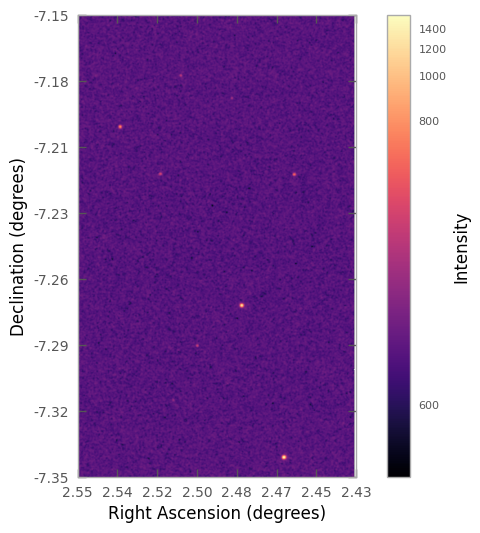

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import simple_norm

#class i made in spring 24

class FITS_analyzer:
    def __init__(self, file):
        self.file = file
    def analyze(self):
        with fits.open(self.file) as hdul:
            image_data = hdul[0].data
            wcs = WCS(hdul[0].header)


        ysize, xsize = image_data.shape

        xcorner, ycorner = wcs.pixel_to_world_values([0, xsize], [0, ysize])


        fig, ax = plt.subplots()


        extent = [xcorner[0], xcorner[1], ycorner[0], ycorner[1]]
        norm = simple_norm(image_data, stretch='log', power=2.0, asinh_a=0.5)
        im = ax.imshow(image_data, cmap='magma', norm=norm, origin='upper', aspect='equal', extent=extent)


        x_ticks = np.linspace(xcorner[0], xcorner[1], 8)
        y_ticks = np.linspace(ycorner[0], ycorner[1], 8)

        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)

        ax.set_xticklabels([f'{val:.2f}' for val in x_ticks], fontsize=10)  
        ax.set_yticklabels([f'{val:.2f}' for val in y_ticks], fontsize=10)  
        ax.tick_params(axis='both', direction='in', length=6, width=1, which='both', top=True, right=True)


        ax.set_xlabel('Right Ascension (degrees)', fontsize=12)  # Specify font size for x-axis label
        ax.set_ylabel('Declination (degrees)', fontsize=12)  # Specify font size for y-axis label
        ax.grid(False)



        cbar = plt.colorbar(im, ax=ax, label='Intensity')
        cbar.ax.tick_params(labelsize=8)  # Specify smaller font size for colorbar ticks
        cbar.set_label('Intensity', fontsize=12)  # Specify font size for colorbar label


file_path = 'image_2MASS-K_s.fits' #had to use relative path, need to update class so that any input(from downloads) will be able to output
analyzer = FITS_analyzer(file_path)
analyzer.analyze()
    
    
            


